## Подбор еды с помощью LangGraph

Рассмотрим сценарий, когда нам нужно подобрать меню для пользователя в некотором ресторане, таким образом, чтобы вино подходило к основному блюду. Для этой задачи, нам потребуется несколько навыков:
* Подбор еды к вину или вина к едё
* Знание меню ресторана и умение отвечать на вопросы по блюдам
* Понимание исходного запроса пользователей

Для каждой из этих задач можем использовать отдельного агента со своими навыками (инструментами) и/или RAG-базой знаний. Для начала, используем код для создания агента из [предыдущего примера](advanced-assistant.ipynb). В код агента для простоты добавим также возможность создания индекса из файлов, и возможность использования структурного вывода.

In [103]:
import os
from yandex_cloud_ml_sdk import YCloudML
from yandex_cloud_ml_sdk.search_indexes import (
    StaticIndexChunkingStrategy,
    HybridSearchIndexType,
    ReciprocalRankFusionIndexCombinationStrategy,
)

folder_id = os.environ["folder_id"]
api_key = os.environ["api_key"]

sdk = YCloudML(folder_id=folder_id, auth=api_key)

# Раскомментируйте, если хотите подробнее смотреть, что делает SDK
#sdk.setup_default_logging(log_level='DEBUG')

model = sdk.models.completions("yandexgpt", model_version="rc")

def create_thread():
    return sdk.threads.create(ttl_days=1, expiration_policy="static")

def create_assistant(model, tools=None):
    kwargs = {}
    if tools and len(tools) > 0:
        kwargs = {"tools": tools}
    return sdk.assistants.create(
        model, ttl_days=1, expiration_policy="since_last_active", **kwargs
    )

def create_search_index(content):
    uploaded = [
        sdk.files.upload_bytes(
            x.encode(), 
            ttl_days=5, 
            expiration_policy="static",
            mime_type="text/markdown")
        for x in content]

    op = sdk.search_indexes.create_deferred(
        uploaded,
        index_type=HybridSearchIndexType(
            chunking_strategy=StaticIndexChunkingStrategy(
                max_chunk_size_tokens=1000, chunk_overlap_tokens=100
            ),
            combination_strategy=ReciprocalRankFusionIndexCombinationStrategy(),
        ),
    )
    return uploaded, op.wait()

class Agent:
    def __init__(self, 
        assistant=None, 
        instruction=None, 
        search_index=None, 
        search_content=None, 
        tools=None,
        response_format=None):

        self.thread = None
        self.uploaded = None
        self.model = model
        self.response_format = response_format

        if assistant:
            self.assistant = assistant
        else:
            if tools:
                self.tools = {x.__name__: x for x in tools}
                tools = [sdk.tools.function(x) for x in tools]
            else:
                self.tools = {}
                tools = []
            if search_index is None and search_content:
                self.uploaded, search_index = create_search_index(search_content)
            if search_index:
                tools.append(sdk.tools.search_index(search_index))
            if response_format:
                self.model = self.model.configure(response_format=response_format)
            self.assistant = create_assistant(self.model, tools)

        if instruction:
            self.assistant.update(instruction=instruction)

    def get_thread(self, thread=None):
        if thread is not None:
            return thread
        if self.thread == None:
            self.thread = create_thread()
        return self.thread

    def __call__(self, message, thread=None):
        thread = self.get_thread(thread)
        thread.write(message)
        run = self.assistant.run(thread)
        res = run.wait()
        if res.tool_calls:
            result = []
            for f in res.tool_calls:
                print(
                    f" + Вызываем функцию {f.function.name}, args={f.function.arguments}"
                )
                fn = self.tools[f.function.name]
                obj = fn(**f.function.arguments)
                x = obj.process(thread)
                result.append({"name": f.function.name, "content": x})
            run.submit_tool_results(result)
            res = run.wait()
        res = res.text
        if self.response_format:
            res = self.response_format.model_validate_json(res[res.index("{"):res.index("}")+1])
        return res 

    def restart(self):
        if self.thread:
            self.thread.delete()
            self.thread = sdk.threads.create(
                name="Test", ttl_days=1, expiration_policy="static"
            )

    def done(self, delete_assistant=False):
        if self.thread:
            self.thread.delete()
        if delete_assistant:
            self.assistant.delete()

def fread(fn):
    with open(fn, encoding='utf-8') as f:
        return f.read()

Для решения нашей задачи будем моделировать поход в ресторан в реальной жизни. У нас будут следующие роли:

* Агент-официант владеет информацией о меню ресторана, и может рекомендовать конкретное блюдо
* Агент-сомелье умеет подбирать сочетания блюд и вина
* Агент-хостесс принимает первоначальные предпочтения посетителя, и далее маршрутизирует диалог между другими агентами для решения задачи.

Создадим этих агентов:

## Агент-официант

Для начала, создадим агента, который владеет меню нашего ресторана. Поскольку меню обычно невелико по объему, то используем для этого RAG, в контекст которого добавим собственно меню:

In [104]:
prompt = """
Ты - официант в ресторане, который должен советовать посетителям блюда и отвечать на вопросы по меню. В твоем распоряжении есть выдержки из меню, которые релевантны запросу. Отвечай на вопрос, используя имеющуюся у тебя на входе информацию, и только её. Не придумывай ничего! 
"""

waiter = Agent(
    search_content=[fread('data/menu/food.md'),fread('data/menu/drinks.md')],
    instruction=prompt)  

In [105]:
waiter("Сколько стоит ливерная колбаса?")

'В меню нет информации о ливерной колбасе.'

In [106]:
waiter("Какое самое дорогое вино?")

'Самое дорогое вино — Пино Нуар от Domaine de la Romanée-Conti, Франция, 2017 год. Цена за бокал — 5200 рублей.'

## Агент-сомелье

Теперь создадим агента, который может дать рекомендации по сочетанию вин и еды. Для этого также используем RAG, как в предыдущем примере:

In [107]:
with open("data/food_wine_table.md", encoding="utf-8") as f:
    food_wine = f.readlines()
header = food_wine[:2]
chunk_size = 600 * 3  # approx 600 tokens * 2 char/token
docs = []
s = header.copy()
for x in food_wine[2:]:
    s.append(x)
    if len("".join(s)) > chunk_size:
        docs.append("".join(s))
        s = header.copy()

In [108]:
prompt = """
Ты - опытный сомелье, который должен рекомендовать клиенту правильные сочетания блюд и вина. Отвечай на просьба подобрать вино к еде или еду к вину, используя имеющуюся у тебя информацию. Также если
пользователь просит посоветовать ему какое-то интересное сочетание - сделай это на основе имеющихся данных. Не придумывай ничего!
"""

sommelier = Agent(
    search_content=docs,
    instruction=prompt)  

In [109]:
sommelier("Какое вино подойдёт к стейку?")

'К стейку из мраморной говядины нежной прожарки (Филе-миньон) подойдут лёгкие и элегантные красные вина из винограда Пино Нуар, Нерелло Маскалезе, выдержанное Мерло. Также можно выбрать «округлые», выдержанные вина из сортов Неббиоло (Барбареско), Темпранильо (Рибейра дель Дуэро), Санджовезе (Кьянти Ризерва).\n\nК жирноватому стейку из мраморной говядины прожарки Rare (Рибай и пр.) рекомендуются выдержанные и «благородные» вина из Темпранильо (Рибейра дель Дуэро или любые от Ризервы и выше), Санджовезе (Кьянти Ризерва, Брунелло), «супертосканские» вина, Бордо Правого берега, шелковистые аргентинские Мальбеки.\n\nК прожарке Medium или WellDone подойдут сухие и полусухие вина из винограда Сира (Шираз), Каберне Совиньон, «тельный» Мальбек, Примитиво, Зинфандель, Альянико (выдержанное и слегка «округлившееся»), выдержанный «ронский» ассамбляж Гренаш+Сира+Мурведр, вина Приората от 6–8 лет выдержки и выше.'

## Агент-хостесс

На входе в ресторан посетителя приветствует хостесс, которая интересуется, что именно хочет есть человек. Для этого заведём специального агента, который будет вычленять из запроса пользователя его предпочтения по вину и по еде. Для этого используем структурный вывод модели.

In [110]:
from pydantic import BaseModel

class PersonPref(BaseModel):
    food_pref : str = ""
    wine_pref : str = ""
    
prompt = """
Ты - официант в ресторане, задача которого принять заказ у посетителя. Тебе необходимо выслушать его и понять, есть ли у него какие-то предпочтения по еде или по вину. Верни ответ в формате json, с полями `food_pref` и `wine_pref`, в которых будут указаны предпочтения. Если нет предпочтений, то верни пустые строки.
"""

hostess = Agent(
    instruction=prompt,
    response_format=PersonPref)

In [111]:
res = hostess("Привет, я хочу поесть что-то из мяса")
res

PersonPref(food_pref='мясо', wine_pref='')

## Собираем агентов вместе: LangGraph

Для объединения агентов вместе будем использовать фреймворк LangGraph. В основе этого фреймворка - идея графа состояний (state machine) и **состояния**, в зависимости от которого определяется дальнейшее поведение системы.

Узлами графа являются функции, которые возвращают **state update** - объект, который обновляет состояние. Для начала опишем класс, который будет определять состояние системы:

In [112]:
import os
from typing import TypedDict, List, Dict, Any, Optional
from langgraph.graph import StateGraph, START, END
from yandex_cloud_ml_sdk._threads.thread import Thread

class RecommenderState(TypedDict):
    message : str
    thread : Thread
    foodpref : str = ""
    winepref : str = ""
    maindish : str
    wine : str
    answer : str
    
def pr(state: RecommenderState):
    return ', '.join([f"{k}={v}" for k,v in state.items() if k!="thread"])

Исходное сообщение пользователя будет в поле `message`, а финальный ответ - в поле `answer`. Мы также будем использовать **общее состояние переписки**, которое будет хранится в виде объекта `Thread` в одноимённом поле. Также начальные преференции пользователя будем хранить в полях `foodpref` и `winepref`, а выбранные блюдо и вино - в полях `maindish` и `wine`.

Логика работы будет такая:
* Вначале извлекаем предпочтения пользователя - за это отвечает функция `welcome` и агент-хостесс
* Основным узлом-маршрутизатором нашей многоагентной системы будет функция `clarify`. Если она видит какие-то из преференций `foodpref` или `winepref` - она выбирает по ним соответствующие блюда из меню с помощью агента-официанта.
* После `clarify` выполняется функция `route_user`, которая определяет, что делать дальше:
   - Если блюда и вино выбраны - мы отправляемся в узел `check_combination`, где с помощью сомелье проверяем, насколько выбранные блюдо и вино сочетаются между собой. Они могут не сочетаться, если пользователь сразу захотел есть стейк с белым вином.
   - Если какая-то из преференций `winepref` или `foodpref` не заполнены - происходит вызов функции `recommend_food` или `recommend_wine`, чтобы с помощью сомелье заполнить этот пробел
   - Если у пользователя нет преференций, то функция `select_random` выбирает для него какое-то блюдо, после чего выполнение агента продолжается с узла `recommend_wine`.

Помимо описания функций для каждого из узлов, нам нужно явным образом добавить узлы в граф с помощью `add_node`, и все переходы между ними, с помощью `add_edge` и `add_conditional_edges`. Дальше получишийся граф можно наприсовать.

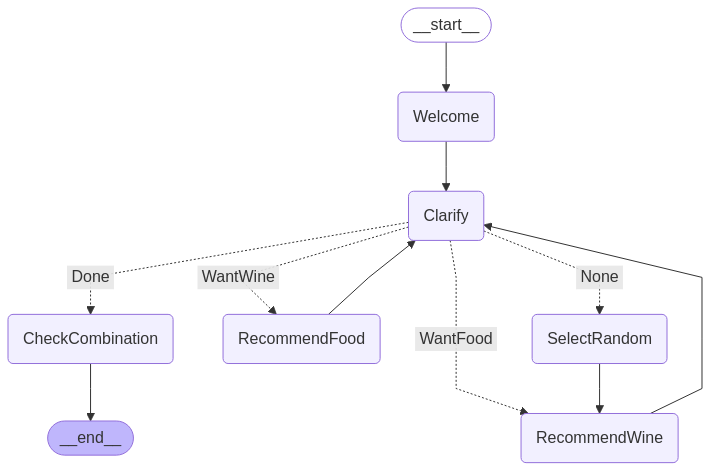

In [113]:
from IPython.display import Image, display

def welcome_user(state: RecommenderState):
    print(f"> Welcome, state={pr(state)}")
    msg = state['message']
    print(f" + Сообщение от пользователя: {msg}")
    res = hostess(msg,state['thread'])
    print(f" + Получены преференции: {res}")
    return {
        'foodpref' : res.food_pref,
        'winepref' : res.wine_pref
    }
    
def route_user(state: RecommenderState) -> str:
    if state.get('maindish') and state.get('wine'): return "Done"
    if state['foodpref'] == "" and state['winepref'] == "": return "None"
    elif state['foodpref'] == "" and state['winepref'] != "": return "WantWine"
    elif state['foodpref'] != "" and state['winepref'] == "": return "WantFood"
    else: return "Both"

def select_random(state: RecommenderState):
    print(f"> SelectRandom, state={pr(state)}")
    maindish = waiter(
        "Порекомендуйте мне какое-нибудь одно основное блюдо. Напиши в ответ только название этого блюда.",
        state["thread"])
    print(f" + Выбрано случайное блюдо: {maindish}")
    return { "maindish" : maindish }
    
def recommend_food(state: RecommenderState):
    print(f"> Recommend Food, state={pr(state)}")
    wine = state.get("wine") or state.get("winepref")
    print(f" + Рекомендуем блюда к вину {wine}")
    foodpref = sommelier(f"Какие типы блюд подойдут к вину {wine}?", state['thread'])
    print(f" + Рекомендации: {foodpref}")
    return { "foodpref" : foodpref }

def recommend_wine(state: RecommenderState):
    print(f"> Recommend wine, state={pr(state)}")
    food = state.get('maindish') or state.get('foodpref')
    print(f" + Рекомендуем вино к блюду {food}")
    winepref = sommelier(f"Какие вина подойдут к блюду {food}?", state['thread'])
    print(f" + Рекомендации: {winepref}")
    return { "winepref" : winepref }
    
def clarify(state: RecommenderState):
    print(f"> Clarify, state={pr(state)}")
    upd = {}
    if state.get("winepref") and not state.get('wine'):
        print(f" + Подбираем вино: {state['winepref']}")
        upd["wine"] = waiter(f"Какое из следующих вин в меню подходит под такое описание: {state['winepref']}? Выбери только одно вино из меню.",state['thread'])
        print(f" + Выбрано вино: {upd['wine']}")
    if state.get("foodpref") and not state.get('maindish'):
        print(f" + Подбираем еду: {state['foodpref']}")
        upd["maindish"] = waiter(f"Какое из следующих блюд в меню подходит под такое описание: {state['foodpref']}?  Выбери только одно блюдо из меню.",state['thread'])
        print(f" + Выбрано блюдо: {upd['maindish']}")
    return upd

def check_combination(state: RecommenderState):
    print(f"> Check combination, state={pr(state)}")
    food = state["maindish"]
    wine = state["wine"]
    print(f" + Проверяем сочетаемость блюда {food} и вина {wine}")
    res = sommelier(f"Сочетается ли блюдо {food} с вином {wine}? Ответь ДА или НЕТ",state['thread'])
    if "нет" in res.lower():
        ans = waiter(f"Тебе хотят заказать следующее блюдо {state['maindish']} и вино {state['wine']}. Напиши вежливый ответ, что это блюдо и вино не очень сочетаются, и предложи выбрать другую комбинацию.",state['thread'])
    else:
        ans = waiter(f"Предложи гостям следующее блюдо {state['maindish']} и вино {state['wine']}.",state['thread'])
    return { "answer" : ans}

def yes_or_no(state: RecommenderState):
    if state["maindish"] and state["wine"]:
        return "Yes"
    else:
        return "No"

recommender_graph = StateGraph(RecommenderState)
recommender_graph.add_node("Welcome", welcome_user)
recommender_graph.add_node("SelectRandom", select_random)
recommender_graph.add_node("RecommendFood", recommend_food)
recommender_graph.add_node("RecommendWine", recommend_wine)
recommender_graph.add_node("CheckCombination", check_combination)
recommender_graph.add_node("Clarify", clarify)

recommender_graph.add_edge(START, "Welcome")
recommender_graph.add_edge("Welcome", "Clarify")
recommender_graph.add_conditional_edges(
    "Clarify",
    route_user,
    {
        "None": "SelectRandom",
        "WantWine" : "RecommendFood",
        "WantFood" : "RecommendWine",
        "Both" : "CheckCombination",
        "Done" : "CheckCombination"
    })
recommender_graph.add_edge("SelectRandom", "RecommendWine")
recommender_graph.add_edge("RecommendFood", "Clarify")
recommender_graph.add_edge("RecommendWine", "Clarify")
recommender_graph.add_edge("CheckCombination", END)

compiled_graph = recommender_graph.compile()

display(Image(compiled_graph.get_graph().draw_mermaid_png()))

Для того, чтобы "поговорить" с этой системой, дадим ей на вход начальное состояние:

In [115]:
res = compiled_graph.invoke(
    {
        "message" : "Привет, я хочу поесть что-то из мяса",
        "thread" : create_thread()
    }
)
res

> Welcome, state=message=Привет, я хочу поесть что-то из мяса
 + Сообщение от пользователя: Привет, я хочу поесть что-то из мяса
 + Получены преференции: food_pref='мясо' wine_pref=''
> Clarify, state=message=Привет, я хочу поесть что-то из мяса, foodpref=мясо, winepref=
 + Подбираем еду: мясо
 + Выбрано блюдо: Стейк «Бык на взводе»
> Recommend wine, state=message=Привет, я хочу поесть что-то из мяса, foodpref=мясо, winepref=, maindish=Стейк «Бык на взводе»
 + Рекомендуем вино к блюду Стейк «Бык на взводе»
 + Рекомендации: К стейку «Бык на взводе» подойдут следующие вина:
* красные вина — сухие и полусухие вина из винограда Гарнача (Гренаш), Мерло, Карменер, Менсия, «тельные» Пино Нуары (со всего света), российский Красностоп, Гамэ (Божоле Виляж);
* как вариант — мощные и выдержанные вина из сортов Каберне Совиньон, Сира, Барбера, Лагрейн, российский Цимлянский Чёрный и Саперави (молодое и «яркое»).
> Clarify, state=message=Привет, я хочу поесть что-то из мяса, foodpref=мясо, winepref=

{'message': 'Привет, я хочу поесть что-то из мяса',
 'thread': Thread(id='fvtp0v4kd14srgjv69r1', expiration_config=ExpirationConfig(ttl_days=1, expiration_policy=<ExpirationPolicy.STATIC: 1>), name=None, description=None, created_by='ajej20rll4tifkelclga', created_at=datetime.datetime(2025, 5, 4, 18, 43, 39, 372043), updated_by='ajej20rll4tifkelclga', updated_at=datetime.datetime(2025, 5, 4, 18, 43, 39, 372043), expires_at=datetime.datetime(2025, 5, 5, 18, 43, 39, 372043), labels=None),
 'foodpref': 'мясо',
 'winepref': 'К стейку «Бык на взводе» подойдут следующие вина:\n* красные вина — сухие и полусухие вина из винограда Гарнача (Гренаш), Мерло, Карменер, Менсия, «тельные» Пино Нуары (со всего света), российский Красностоп, Гамэ (Божоле Виляж);\n* как вариант — мощные и выдержанные вина из сортов Каберне Совиньон, Сира, Барбера, Лагрейн, российский Цимлянский Чёрный и Саперави (молодое и «яркое»).',
 'maindish': 'Стейк «Бык на взводе»',
 'wine': 'Каберне Совиньон от Château Lafite Ro

Можем также посмотреть переписку всех агентов в Thread:

In [119]:
for msg in list(res['thread'])[::-1]:
    print(f"{msg.role}: {msg.text}")

USER: Привет, я хочу поесть что-то из мяса
ASSISTANT: ```
{
  "food_pref": "мясо",
  "wine_pref": ""
}
```
USER: Какое из следующих блюд в меню подходит под такое описание: мясо?  Выбери только одно блюдо из меню.
ASSISTANT: Стейк «Бык на взводе»
USER: Какие вина подойдут к блюду Стейк «Бык на взводе»?
ASSISTANT: К стейку «Бык на взводе» подойдут следующие вина:
* красные вина — сухие и полусухие вина из винограда Гарнача (Гренаш), Мерло, Карменер, Менсия, «тельные» Пино Нуары (со всего света), российский Красностоп, Гамэ (Божоле Виляж);
* как вариант — мощные и выдержанные вина из сортов Каберне Совиньон, Сира, Барбера, Лагрейн, российский Цимлянский Чёрный и Саперави (молодое и «яркое»).
USER: Какое из следующих вин в меню подходит под такое описание: К стейку «Бык на взводе» подойдут следующие вина:
* красные вина — сухие и полусухие вина из винограда Гарнача (Гренаш), Мерло, Карменер, Менсия, «тельные» Пино Нуары (со всего света), российский Красностоп, Гамэ (Божоле Виляж);
* как в

Рассмотрим пример, когда пользователь хочет изначально не слишком хорошее сочетание:

In [121]:
res = compiled_graph.invoke(
    {
        "message" : "Привет, я хочу съесть какое-то рыбное блюдо с мерло!",
        "thread" : create_thread()
    }
)
print(res['answer'])

> Welcome, state=message=Привет, я хочу съесть какое-то рыбное блюдо с мерло!
 + Сообщение от пользователя: Привет, я хочу съесть какое-то рыбное блюдо с мерло!
 + Получены преференции: food_pref='рыбное блюдо' wine_pref='мерло'
> Clarify, state=message=Привет, я хочу съесть какое-то рыбное блюдо с мерло!, foodpref=рыбное блюдо, winepref=мерло
 + Подбираем вино: мерло
 + Выбрано вино: Мерло от Marchesi Antinori, Италия, 2019 год.
 + Подбираем еду: рыбное блюдо
 + Выбрано блюдо: «Лосось в мечтах о Норвегии»
> Check combination, state=message=Привет, я хочу съесть какое-то рыбное блюдо с мерло!, foodpref=рыбное блюдо, winepref=мерло, maindish=«Лосось в мечтах о Норвегии», wine=Мерло от Marchesi Antinori, Италия, 2019 год.
 + Проверяем сочетаемость блюда «Лосось в мечтах о Норвегии» и вина Мерло от Marchesi Antinori, Италия, 2019 год.
Здравствуйте!

Спасибо за ваш выбор. К сожалению, «Лосось в мечтах о Норвегии» и мерло от Marchesi Antinori, Италия, 2019 год не очень хорошо сочетаются. Мо

И наконец случай, когда у пользователя нет предпочтений:

In [122]:
compiled_graph.invoke(
    {
        "message" : "Что вкусного есть у вас сегодня?",
        "thread" : create_thread()
    }
)

> Welcome, state=message=Что вкусного есть у вас сегодня?
 + Сообщение от пользователя: Что вкусного есть у вас сегодня?
 + Получены преференции: food_pref='' wine_pref=''
> Clarify, state=message=Что вкусного есть у вас сегодня?, foodpref=, winepref=
> SelectRandom, state=message=Что вкусного есть у вас сегодня?, foodpref=, winepref=
 + Выбрано случайное блюдо: Стейк «Бык на взводе»
> Recommend wine, state=message=Что вкусного есть у вас сегодня?, foodpref=, winepref=, maindish=Стейк «Бык на взводе»
 + Рекомендуем вино к блюду Стейк «Бык на взводе»
 + Рекомендации: К блюду «Стейк „Бык на взводе“» могут подойти следующие вина:
* Красные вина: сухие и полусухие вина из винограда Гарнача (Гренаш), Мерло, Карменер, Менсия, «тельные» Пино Нуары (со всего света), российский Красностоп, Гамэ (Божоле Виляж).
> Clarify, state=message=Что вкусного есть у вас сегодня?, foodpref=, winepref=К блюду «Стейк „Бык на взводе“» могут подойти следующие вина:
* Красные вина: сухие и полусухие вина из вино

{'message': 'Что вкусного есть у вас сегодня?',
 'thread': Thread(id='fvto3n7eplhpfdqoo5ea', expiration_config=ExpirationConfig(ttl_days=1, expiration_policy=<ExpirationPolicy.STATIC: 1>), name=None, description=None, created_by='ajej20rll4tifkelclga', created_at=datetime.datetime(2025, 5, 4, 18, 47, 36, 488365), updated_by='ajej20rll4tifkelclga', updated_at=datetime.datetime(2025, 5, 4, 18, 47, 36, 488365), expires_at=datetime.datetime(2025, 5, 5, 18, 47, 36, 488365), labels=None),
 'foodpref': '',
 'winepref': 'К блюду «Стейк „Бык на взводе“» могут подойти следующие вина:\n* Красные вина: сухие и полусухие вина из винограда Гарнача (Гренаш), Мерло, Карменер, Менсия, «тельные» Пино Нуары (со всего света), российский Красностоп, Гамэ (Божоле Виляж).',
 'maindish': 'Стейк «Бык на взводе»',
 'wine': 'Мерло от Marchesi Antinori, Италия.',
 'answer': 'Стейк «Бык на взводе» — это сочный рибай с розовым сердцем, томлёный в дыме аргентинских страстей, который подаётся с золотой солью Гималаев

## Удаляем лишнее

После демонстрации мы можем удалить все ассистенты, файлы, индексы и переписки.

**ВНИМАНИЕ:** Код ниже удаляет все ассистенты, файлы, индексы и переписки в каталоге, с которым работает Yandex Cloud ML SDK. Если у вас есть другие проекты, использующие ассистентов, то лучше не выполняйте этот код, а дождитесь, когда объекты будут сами удалены по TTL.

In [123]:
from tqdm.auto import tqdm

for thread in tqdm(sdk.threads.list()):
    try:
        thread.delete()
    except:
        pass

for assistant in tqdm(sdk.assistants.list()):
    assistant.delete()

for index in tqdm(sdk.search_indexes.list()):
    index.delete()
    
for file in tqdm(sdk.files.list()):
    file.delete()

31it [00:02, 10.65it/s]
3it [00:00, 10.82it/s]
2it [00:00,  5.72it/s]
24it [00:02, 10.61it/s]
